In [1]:
import numpy as np 
from qiskit import QuantumCircuit

In [2]:
def generate_H(N, v, c):
    """
    Generates an LDPC parity-check matrix following the algorithm in Gallager's 1963 thesis. 
    https://web.stanford.edu/class/ee388/papers/ldpc.pdf
    NOTE: c must divide N for a regular LDPC code. 
    """
    seed = 2

    n_equations = (N * v) // c

    block = np.zeros((n_equations // v, N))
    H = np.empty((n_equations, N))
    block_size = n_equations // v

    # Filling the first block with consecutive ones in each row of the block

    for i in range(block_size):
        for j in range(i * c, (i+1) * c):
            block[i, j] = 1
    H[:block_size] = block

    # Create remaining blocks by permutations of the first block's columns:
    for i in range(1, v):
        #print(block)
        H[i * block_size: (i + 1) * block_size] = np.random.RandomState(seed).permutation(block.T).T
    H = H.astype(int)
    return H

In [3]:
# H_X matrix from https://arxiv.org/pdf/2405.07242
Hx = np.array([
    [1, 0, 0, 0, 1, 0, 0, 0, 1, 1],
    [0, 1, 0, 0, 0, 1, 1, 0, 0, 1],
    [0, 0, 1, 1, 0, 0, 0, 1, 0, 1]
])

# H_Z matrix
Hz = np.array([
    [1, 0, 0, 0, 0, 1, 0, 1, 0, 1],
    [0, 1, 0, 1, 0, 0, 0, 0, 1, 1],
    [0, 0, 1, 0, 1, 0, 1, 0, 0, 1]
])

zeros = np.zeros(Hx.shape)
H0 = np.concatenate((np.concatenate((Hx, zeros), axis=1), np.concatenate((zeros, Hz), axis=1))) #in the standard form for a CSS code

In [4]:
def print_stabilizers(H_sub, stab):
    for n in range(len(H_sub)):
        curr_str = ''
        row = H_sub[n]
        for m in row:
            if m:
                curr_str += stab
            else:
                curr_str += 'I'
        print(curr_str)

In [5]:
print_stabilizers(Hx, 'X')

XIIIXIIIXX
IXIIIXXIIX
IIXXIIIXIX


In [6]:
#def make_stabilizer_circ(Hx, Hz):
qc = QuantumCircuit(Hx.shape[1] + Hx.shape[0] + Hz.shape[0], Hx.shape[0] + Hz.shape[0])
x_offset = Hx.shape[1] 
z_offset = Hx.shape[1] + Hx.shape[0] 

for i in range(len(Hx)):
    row  = Hx[i] 
    #print(row)
    for j in range(len(row)):
        curr = row[j]
        #print(curr)
        if curr:
            #print(i, j, curr)
            qc.cx(j, i + x_offset) #need to track offset 
            print("Added X stabilizer from qubit " + str(j) + " to ancilla " + str(i))
            qc.barrier()

for i in range(len(Hz)):
    row  = Hz[i] 
    #print(row)
    for j in range(len(row)):
        curr = row[j]
        #print(curr)
        if curr:
            #print(i, j, curr)
            qc.cz(j, i + z_offset) #need to track offset 
            print("Added X stabilizer from qubit " + str(j) + " to ancilla " + str(i))
            qc.barrier()

qc.measure(range(Hx.shape[1], Hx.shape[1] + Hx.shape[0] + Hz.shape[0]), range(Hx.shape[0] + Hz.shape[0]))

Added X stabilizer from qubit 0 to ancilla 0
Added X stabilizer from qubit 4 to ancilla 0
Added X stabilizer from qubit 8 to ancilla 0
Added X stabilizer from qubit 9 to ancilla 0
Added X stabilizer from qubit 1 to ancilla 1
Added X stabilizer from qubit 5 to ancilla 1
Added X stabilizer from qubit 6 to ancilla 1
Added X stabilizer from qubit 9 to ancilla 1
Added X stabilizer from qubit 2 to ancilla 2
Added X stabilizer from qubit 3 to ancilla 2
Added X stabilizer from qubit 7 to ancilla 2
Added X stabilizer from qubit 9 to ancilla 2
Added X stabilizer from qubit 0 to ancilla 0
Added X stabilizer from qubit 5 to ancilla 0
Added X stabilizer from qubit 7 to ancilla 0
Added X stabilizer from qubit 9 to ancilla 0
Added X stabilizer from qubit 1 to ancilla 1
Added X stabilizer from qubit 3 to ancilla 1
Added X stabilizer from qubit 8 to ancilla 1
Added X stabilizer from qubit 9 to ancilla 1
Added X stabilizer from qubit 2 to ancilla 2
Added X stabilizer from qubit 4 to ancilla 2
Added X st

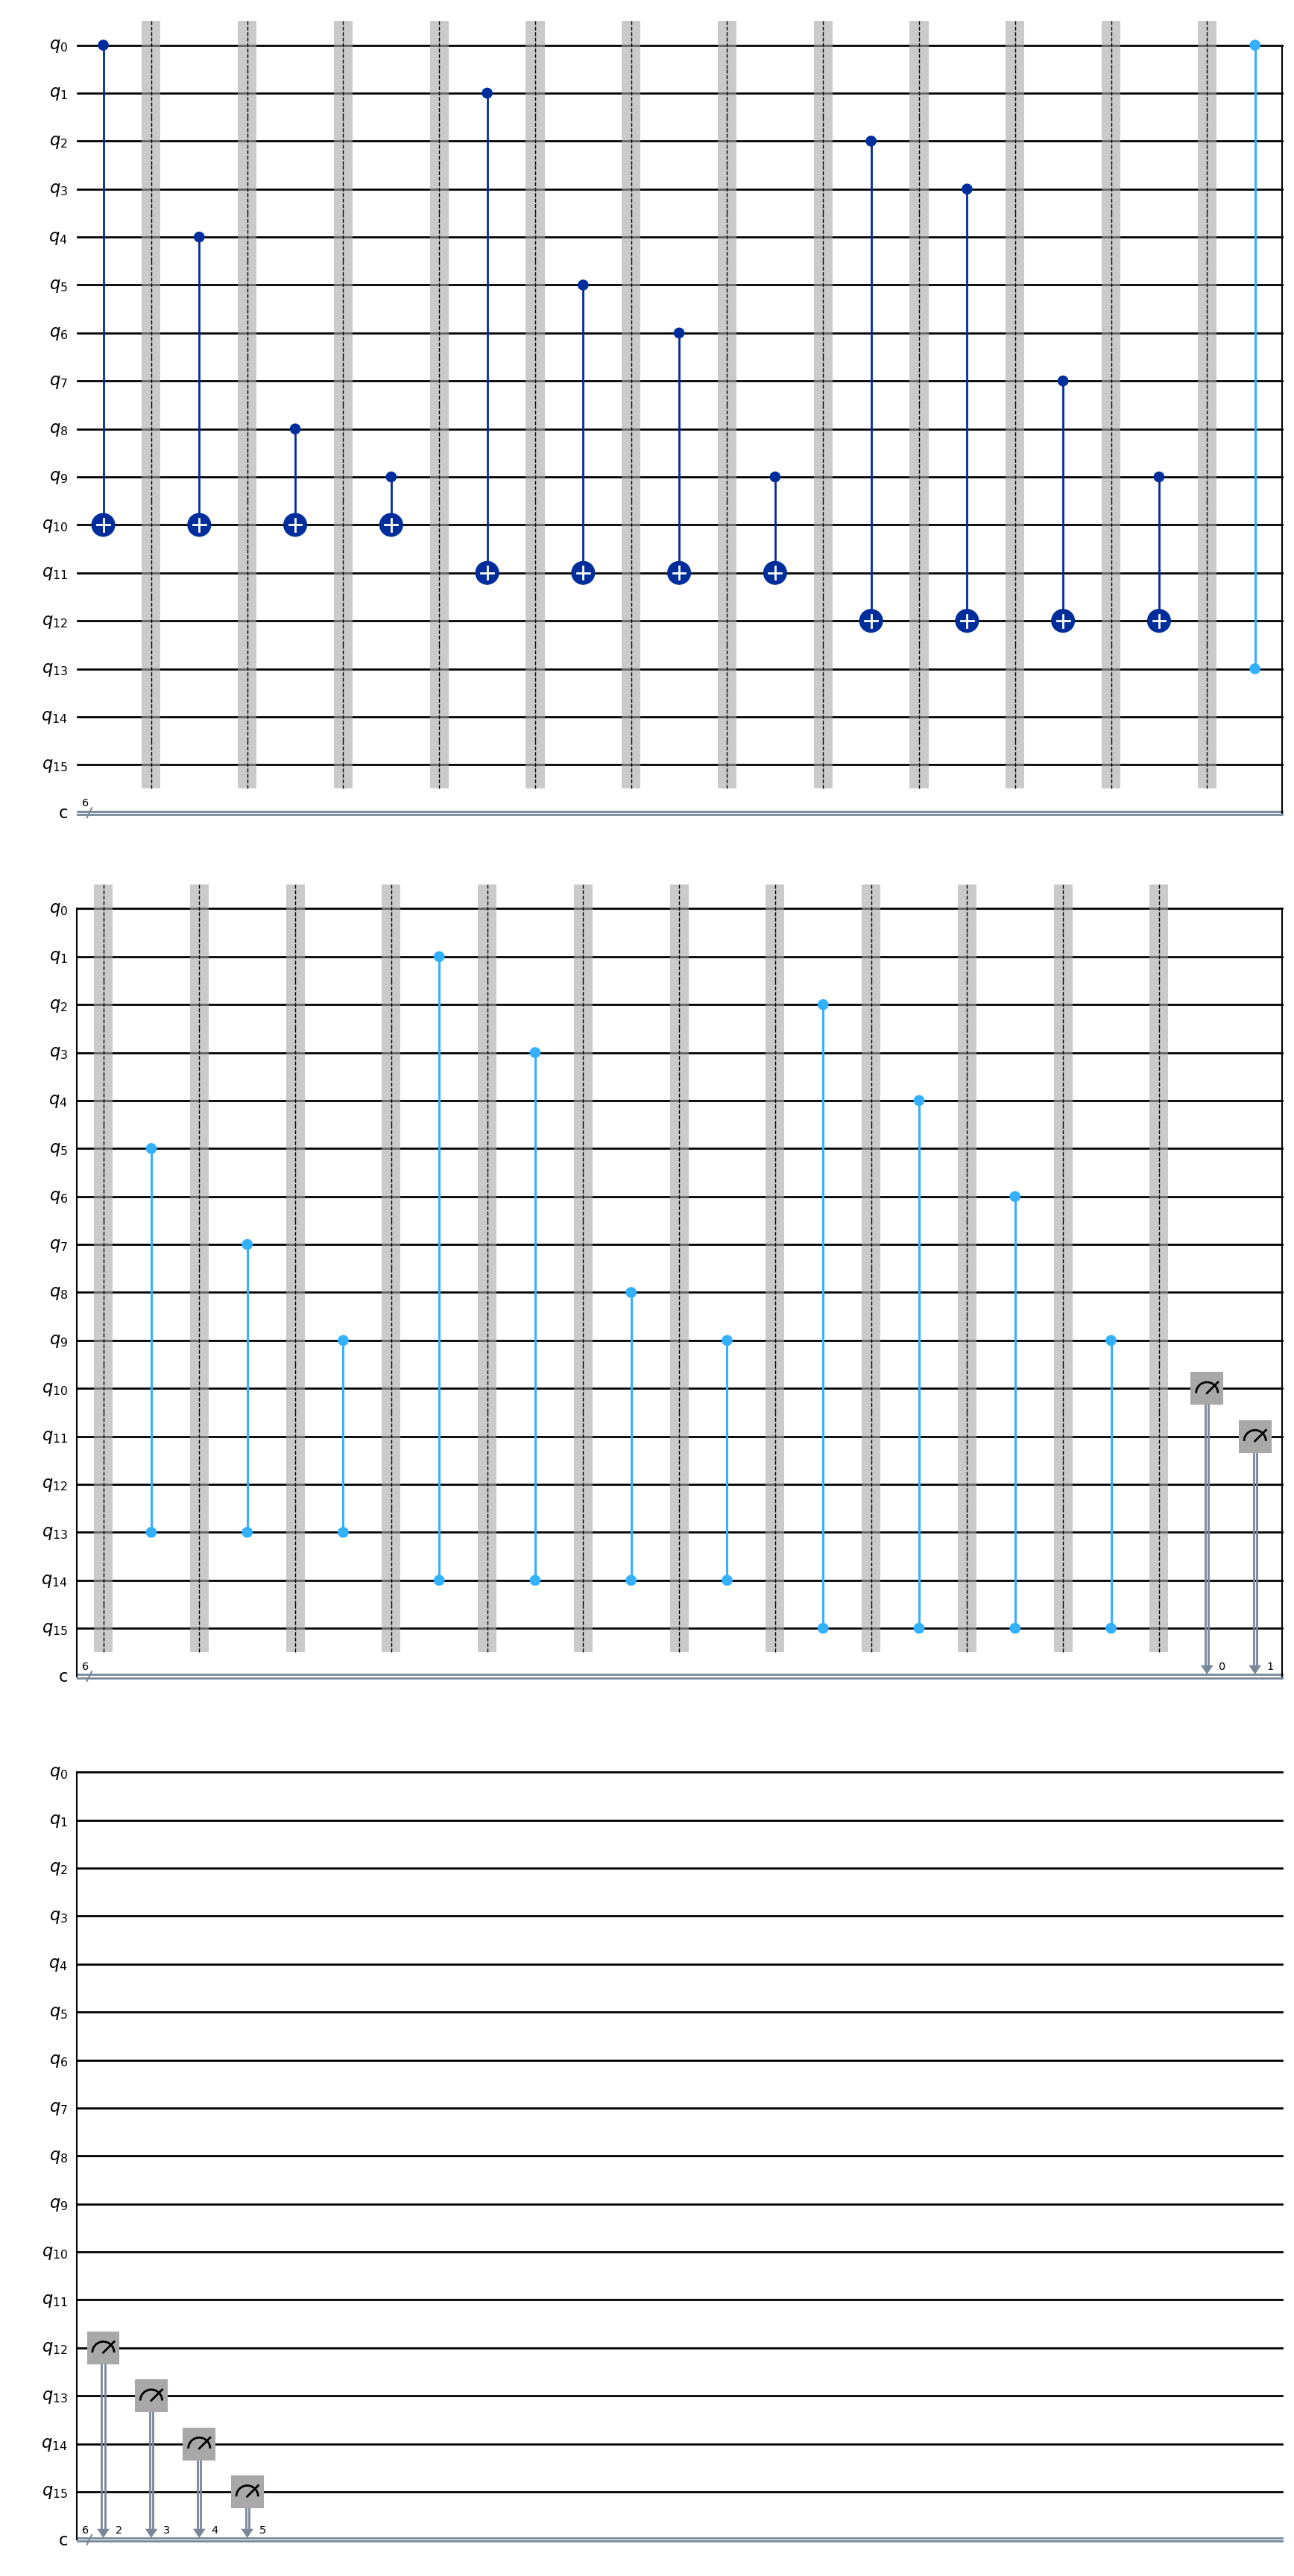

In [7]:
qc.draw(output="mpl")

In [15]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator, Aer
from qiskit_aer.primitives import EstimatorV2
from qiskit import transpile

In [16]:
# Transpile the circuit for the qasm simulator
simulator = Aer.get_backend('qasm_simulator')
transpiled_circuit = transpile(qc, backend=simulator)

# Simulate the circuit
job = simulator.run(transpiled_circuit, shots=1024)
result = job.result()
counts = result.get_counts()

# Display the measurement results
print("Measurement results:")
print(counts)

# Calculate expectation values of stabilizers
stabilizers = []
for i in range(len(Hx)):
    row = Hx[i]
    pauli_str = ""
    for j in range(len(row)):
        if row[j] == 1:
            pauli_str += "X"
        else:
            pauli_str += "I"
    pauli_str += "I" * len(Hz)
    stabilizers.append(pauli_str)

for i in range(len(Hz)):
    row = Hz[i]
    pauli_str = "I" * len(Hx[0])
    for j in range(len(row)):
        if row[j] == 1:
            pauli_str += "Z"
        else:
            pauli_str += "I"
    stabilizers.append(pauli_str)

print("\nStabilizer operators:")
print(stabilizers)

# Expectation value calculation
expectation_values = {}
for stabilizer in stabilizers:
    pauli_op = SparsePauliOp.from_list([(stabilizer, 1)])
    exp_val = result.get_counts(qc)
    expectation_values[stabilizer] = exp_val

print("\nExpectation values:")
for stabilizer, value in expectation_values.items():
    print(f"{stabilizer}: {value}")

Measurement results:
{'000000': 1024}

Stabilizer operators:
['XIIIXIIIXXIII', 'IXIIIXXIIXIII', 'IIXXIIIXIXIII', 'IIIIIIIIIIZIIIIZIZIZ', 'IIIIIIIIIIIZIZIIIIZZ', 'IIIIIIIIIIIIZIZIZIIZ']

Expectation values:
XIIIXIIIXXIII: {'000000': 1024}
IXIIIXXIIXIII: {'000000': 1024}
IIXXIIIXIXIII: {'000000': 1024}
IIIIIIIIIIZIIIIZIZIZ: {'000000': 1024}
IIIIIIIIIIIZIZIIIIZZ: {'000000': 1024}
IIIIIIIIIIIIZIZIZIIZ: {'000000': 1024}


In [18]:
# Adjust stabilizers to match the number of measured qubits
num_measured_qubits = len(Hx) + len(Hz)  # Number of stabilizer measurements
aligned_stabilizers = [stabilizer[:num_measured_qubits] for stabilizer in stabilizers]

def compute_stabilizer_expectation(counts, stabilizer):
    expectation = 0
    total_shots = sum(counts.values())
    
    for bitstring, count in counts.items():
        parity = 1
        for i, char in enumerate(stabilizer):
            if char == 'X' or char == 'Z':
                parity *= (-1) ** int(bitstring[i])  # Flip sign based on bit value
        expectation += parity * count
    
    return expectation / total_shots

# Compute expectation values for aligned stabilizers
print("\nStabilizer Expectation Values:")
for stabilizer in aligned_stabilizers:
    expectation = compute_stabilizer_expectation(counts, stabilizer)
    print(f"{stabilizer}: {expectation}")





Stabilizer Expectation Values:
XIIIXI: 1.0
IXIIIX: 1.0
IIXXII: 1.0
IIIIII: 1.0
IIIIII: 1.0
IIIIII: 1.0


In [10]:
observable = SparsePauliOp("Z" * 6)
params = [0.1] * qc.num_parameters
 
exact_estimator = Estimator()
# The circuit needs to be transpiled to the AerSimulator target
pass_manager = generate_preset_pass_manager(3, AerSimulator())
isa_circuit = pass_manager.run(qc)
pub = (isa_circuit, observable, params)

NameError: name 'Estimator' is not defined

In [119]:
noise_model = NoiseModel()
cx_depolarizing_prob = 0.02
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
)

In [120]:
noisy_estimator = Estimator(
    options=dict(backend_options=dict(noise_model=noise_model))
)

TypeError: Estimator.__init__() got an unexpected keyword argument 'options'